В этом ноутбуке представлен процесс обучения и сравнения сверточных нейросетей для задачи классификации лиц по наличию очков.

*   Автор: Соловьева Екатерина
*   GitHub Repository: https://github.com/qksolov/eyewear-counter


**Содержание:**
1. Постановка задачи
2. Импорты и конфигурация
2. Данные и аугментация
3. Обучение моделей  
4. Сравнение моделей по метрикам  
5. Анализ ошибок и предсказаний

# 1. Постановка задачи




**Задача:** по изображению лица, вырезанному детектором, определить один из трёх классов
- `glasses` — в очках,
- `plain` — без очков,
- `sunglasses` — в солнцезащитных очках.

Особое внимание уделяется качеству распознавания людей в очках — важно минимизировать пропуски, поэтому при сравнении моделей акцент сделан на метрики **recall** и **F2-score** для этого класса. Кроме того, учитывается скорость инференса, так как задача решается в онлайн-сценарии.

> *Примечание:*
>
> На раннем этапе проекта использовался детектор лиц MTCNN, допускавший около 5% ложноположительных срабатываний. Была попытка расширить задачу до 4 классов с добавлением категории `notface` (для фильтрации ошибочных детекций). Однако классификатор начал часто ошибочно относить реальные лица к классу "не лицо". Впоследствии были найдены более надёжные и быстрые модели детекции (подробнее об этом в ноутбуке `test_detectors.ipynb`), и в итоге было принято решение вернуться к 3-классовой задаче.

# 2. Импорты и конфигурация

In [ ]:
!pip install -q grad-cam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
!apt-get install unrar > /dev/null
!unrar x "/content/data.rar" "/content" > /dev/null

In [ ]:
DATA_DIR = "/content/data/"
MODELS_DIR = "/content/drive/MyDrive/models/"

NUM_CLASSES = 3
CLASS_NAMES = ['glasses', 'plain', 'sunglasses']
GLASSES_IDX = 0

BATCH_SIZE = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cuda


# 3. Данные и аугментации

В качестве исходного источника использовались изображения из **Open Images Dataset V6**, содержащие разметку объектов `Glasses` и `Sunglasses`. Однако эта аннотация касалась объектов, а не лиц, и в большинстве случаев пересекалась, что делало её непригодной для прямого использования.

**Подготовка данных**
-  Для выделения лиц на изображениях использовался детектор на базе **YOLO**.

- После детекции каждое лицо вручную классифицировалось к одному из 3 классов: `glasses`, `plain`, `sunglasses`.


**Очистка и фильтрация**
- При разметке изредка встречались лица с нетипичными аксессуарами (например, очки для плавания или маски). Такие случаи не входили в целевую задачу и были исключены.

- Редкие ложноположительные детекции (например, головы животных) также удалялись.

- Из-за особенностей YOLO, обученного на WIDERFace, иногда обнаруживались мелкие лица с низким разрешением, на которых невозможно было достоверно определить наличие очков. Так как проект предполагает ограничение на количество лиц на фото, такие случаи также были отброшены.

### 3.1. Создание датасетов и загрузчиков

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(
    root=DATA_DIR + 'train', transform=train_transform)
val_dataset = datasets.ImageFolder(
    root=DATA_DIR + 'val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)

In [ ]:
print(CLASS_NAMES == list(train_dataset.class_to_idx.keys()))

True


**Распределение данных по классам**

Данные были разделены в пропорции 80/20 на обучающую и валидационную выборки.

Классы распределены достаточно равномерно, что позволяет избежать существенного дисбаланса при обучении.

Общее количество изображений сравнительно небольшое, но достаточное для использования предобученных моделей и их последующего тонкого дообучения под данную задачу.


In [ ]:
from collections import Counter
import pandas as pd

train_counts = Counter(train_dataset.targets)
val_counts = Counter(val_dataset.targets)

df = pd.DataFrame({
    "Class": [CLASS_NAMES[cls] for cls in range(NUM_CLASSES)],
    "Train": [train_counts[cls] for cls in range(NUM_CLASSES)],
    "Validation": [val_counts[cls]for cls in range(NUM_CLASSES)]
})

print(df)
print("\nTotal train images:", len(train_dataset))
print("Total val images:", len(val_dataset))

        Class  Train  Validation
0     glasses   1711         427
1       plain   1942         486
2  sunglasses   1661         416

Total train images: 5314
Total val images: 1329


### 3.3. Примеры данных

Ниже представлены примеры изображений из обучающей и валидационной выборок.

Датасет включает лица разных ракурсов, освещения и разрешения, а также очки различных форм и цветов.

In [ ]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)

def show_images(images, titles=None, overall_title=None, denorm=True):
    num_images = len(images)

    plt.figure(figsize=(6.2, 2))

    for i, img in enumerate(images):
        if denorm:
            img = denormalize(img).permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i], fontsize=9)
        plt.axis('off')

    if overall_title:
        plt.suptitle(overall_title, fontsize=16, y=0.85 if titles is None else 1.05)

    plt.tight_layout()
    plt.show()

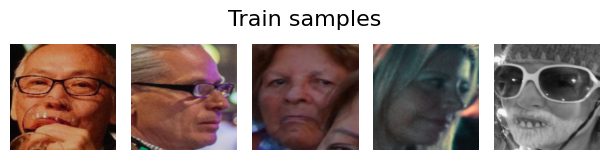

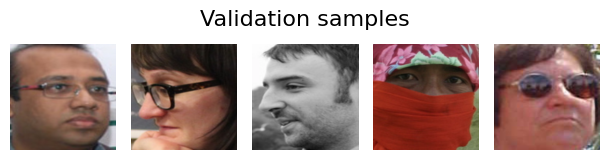

In [ ]:
images = [train_dataset[i][0] for i in [1, 3, 2000, 2400, -1]]
show_images(images[:5], overall_title='Train samples')

VAL_SAMPLES = [0, 48, 460, 461, -1]
images = [val_dataset[i][0] for i in VAL_SAMPLES]
show_images(images, overall_title='Validation samples')

### 3.4. Аугментация

Для увеличения разнообразия обучающей выборки использовались следующие аугментации:

- случайное горизонтальное отражение,
- лёгкое размытие,
- изменение цветовых характеристик,
- случайное преобразование в полутон.


```
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
```

Поворот изображений не применялся, так как перед классификатором в пайплайне используется детектор. Изменение ориентации могло бы нарушить расположение лица относительно выдаваемых bounding box.

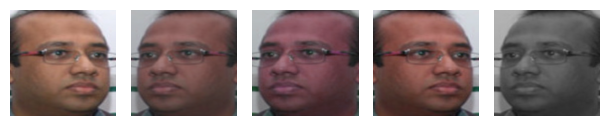

In [ ]:
img = val_dataset[0][0]
npimg =  torchvision.transforms.ToPILImage()(denormalize(img))
images = [img] + [train_transform(npimg) for _ in range(4)]
show_images(images, 'Data augmentation')

# 4. Обучение

In [ ]:
def train(model, epochs, lr, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    patience = 3
    no_improve = 0
    best_recall = 0
    best_f2 = 0
    best_loss = float('inf')


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1:02d}/{epochs:02d}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100. * accuracy_score(all_val_labels, all_val_preds)

        # Метрики по классу glasses
        y_true_glasses = (np.array(all_val_labels) == GLASSES_IDX).astype(int)
        y_pred_glasses = (np.array(all_val_preds) == GLASSES_IDX).astype(int)

        val_precision = precision_score(y_true_glasses, y_pred_glasses, zero_division=0)
        val_recall = recall_score(y_true_glasses, y_pred_glasses)
        val_f2 = fbeta_score(y_true_glasses, y_pred_glasses, beta=2)

        print(f'Train | Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%')
        print(f'Val   | Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%')
        print(f'Val Glasses | Prec: {val_precision:.2f} | Rec: {val_recall:.2f} | F2: {val_f2:.2f}')

        if val_loss > best_loss - 0.003:
            no_improve += 1
            if no_improve >= patience:
                print(f"Ранняя остановка на эпохе {epoch+1}!")
                break
        else:
            no_improve = 0

        if val_acc > 90 and (val_loss < best_loss - 0.003 or val_recall > best_recall + 0.005 or val_f2 > best_f2 + 0.005):
            best_loss = min(val_loss, best_loss)
            best_recall = max(val_recall, best_recall)
            best_f2 = max(val_f2, best_f2)
            torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'{model_name}_{epoch+1}.pt'))
            print(f"Сохранение модели на эпохе {epoch+1}!")

        print('')


In [ ]:
best_models = []

## 4.1. MobileNet v3 small

In [ ]:
models.mobilenet_v3_small()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### mobilenet_s_u0
Разморожен только классификатор

In [ ]:
mobilenet_s_u0 = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

In [ ]:
for param in mobilenet_s_u0.parameters():
    param.requires_grad = False

mobilenet_s_u0.classifier[-1] = nn.Linear(mobilenet_s_u0.classifier[-1].in_features, NUM_CLASSES)

for param in mobilenet_s_u0.classifier.parameters():
    param.requires_grad = True

print("Размороженные слои:")
for name, param in mobilenet_s_u0.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [ ]:
train(mobilenet_s_u0, epochs=15, lr=0.001, model_name='mobilenet_s_u0')

Epoch 01/15: 100%|██████████| 167/167 [00:54<00:00,  3.06it/s]


Train | Loss: 0.4816 | Acc: 79.92%
Val   | Loss: 0.3919 | Acc: 84.20%
Val Glasses | Prec: 0.89 | Rec: 0.75 | F2: 0.78



Epoch 02/15: 100%|██████████| 167/167 [00:53<00:00,  3.13it/s]


Train | Loss: 0.3879 | Acc: 84.72%
Val   | Loss: 0.4256 | Acc: 82.54%
Val Glasses | Prec: 0.86 | Rec: 0.78 | F2: 0.79



Epoch 03/15: 100%|██████████| 167/167 [00:53<00:00,  3.15it/s]


Train | Loss: 0.3627 | Acc: 86.23%
Val   | Loss: 0.3505 | Acc: 85.40%
Val Glasses | Prec: 0.94 | Rec: 0.72 | F2: 0.75



Epoch 04/15: 100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Train | Loss: 0.3511 | Acc: 86.21%
Val   | Loss: 0.3128 | Acc: 87.28%
Val Glasses | Prec: 0.83 | Rec: 0.89 | F2: 0.88



Epoch 05/15: 100%|██████████| 167/167 [00:52<00:00,  3.15it/s]


Train | Loss: 0.3219 | Acc: 87.64%
Val   | Loss: 0.3301 | Acc: 86.23%
Val Glasses | Prec: 0.77 | Rec: 0.92 | F2: 0.89



Epoch 06/15: 100%|██████████| 167/167 [00:52<00:00,  3.15it/s]


Train | Loss: 0.3016 | Acc: 88.05%
Val   | Loss: 0.3023 | Acc: 87.36%
Val Glasses | Prec: 0.87 | Rec: 0.83 | F2: 0.84



Epoch 07/15: 100%|██████████| 167/167 [00:52<00:00,  3.16it/s]


Train | Loss: 0.2846 | Acc: 89.05%
Val   | Loss: 0.2926 | Acc: 88.26%
Val Glasses | Prec: 0.86 | Rec: 0.88 | F2: 0.88



Epoch 08/15: 100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Train | Loss: 0.2805 | Acc: 89.14%
Val   | Loss: 0.3586 | Acc: 85.33%
Val Glasses | Prec: 0.78 | Rec: 0.91 | F2: 0.88



Epoch 09/15: 100%|██████████| 167/167 [00:54<00:00,  3.09it/s]


Train | Loss: 0.2748 | Acc: 88.78%
Val   | Loss: 0.2913 | Acc: 88.26%
Val Glasses | Prec: 0.84 | Rec: 0.89 | F2: 0.88



Epoch 10/15: 100%|██████████| 167/167 [00:59<00:00,  2.79it/s]


Train | Loss: 0.2370 | Acc: 90.53%
Val   | Loss: 0.2927 | Acc: 87.66%
Val Glasses | Prec: 0.88 | Rec: 0.83 | F2: 0.84



Epoch 11/15: 100%|██████████| 167/167 [00:57<00:00,  2.92it/s]


Train | Loss: 0.2384 | Acc: 90.70%
Val   | Loss: 0.3202 | Acc: 87.51%
Val Glasses | Prec: 0.84 | Rec: 0.89 | F2: 0.88



Epoch 12/15: 100%|██████████| 167/167 [00:55<00:00,  3.02it/s]


Train | Loss: 0.2474 | Acc: 90.35%
Val   | Loss: 0.3660 | Acc: 84.50%
Val Glasses | Prec: 0.76 | Rec: 0.87 | F2: 0.85



Epoch 13/15: 100%|██████████| 167/167 [00:53<00:00,  3.15it/s]


Train | Loss: 0.2557 | Acc: 90.78%
Val   | Loss: 0.3254 | Acc: 87.89%
Val Glasses | Prec: 0.85 | Rec: 0.87 | F2: 0.86



Epoch 14/15: 100%|██████████| 167/167 [00:56<00:00,  2.96it/s]


Train | Loss: 0.2434 | Acc: 90.85%
Val   | Loss: 0.3308 | Acc: 87.89%
Val Glasses | Prec: 0.89 | Rec: 0.84 | F2: 0.85



Epoch 15/15: 100%|██████████| 167/167 [00:52<00:00,  3.18it/s]


Train | Loss: 0.2222 | Acc: 91.23%
Val   | Loss: 0.2936 | Acc: 89.47%
Val Glasses | Prec: 0.88 | Rec: 0.86 | F2: 0.87



### mobilenet_s_u1
Разморожен классификатор + 1 сверточный блок

In [ ]:
mobilenet_s_u1 = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

In [ ]:
for param in mobilenet_s_u1.parameters():
    param.requires_grad = False

mobilenet_s_u1.classifier[-1] = nn.Linear(mobilenet_s_u1.classifier[-1].in_features, NUM_CLASSES)

for param in mobilenet_s_u1.classifier.parameters():
    param.requires_grad = True

for param in mobilenet_s_u1.features[-1].parameters():
    param.requires_grad = True

print("Размороженные слои:")
for name, param in mobilenet_s_u1.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
features.12.0.weight
features.12.1.weight
features.12.1.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [ ]:
train(mobilenet_s_u1, epochs=15, lr=0.001, model_name='mobilenet_s_u1')

Epoch 01/15: 100%|██████████| 167/167 [00:55<00:00,  3.03it/s]


Train | Loss: 0.4353 | Acc: 82.50%
Val   | Loss: 0.4798 | Acc: 80.96%
Val Glasses | Prec: 0.89 | Rec: 0.74 | F2: 0.77



Epoch 02/15: 100%|██████████| 167/167 [00:54<00:00,  3.05it/s]


Train | Loss: 0.3098 | Acc: 87.86%
Val   | Loss: 0.2625 | Acc: 89.99%
Val Glasses | Prec: 0.85 | Rec: 0.90 | F2: 0.89



Epoch 03/15: 100%|██████████| 167/167 [00:53<00:00,  3.12it/s]


Train | Loss: 0.2734 | Acc: 89.52%
Val   | Loss: 0.2357 | Acc: 90.29%
Val Glasses | Prec: 0.87 | Rec: 0.89 | F2: 0.89
Сохранение модели на эпохе 3!



Epoch 04/15: 100%|██████████| 167/167 [00:54<00:00,  3.09it/s]


Train | Loss: 0.2891 | Acc: 89.86%
Val   | Loss: 0.2508 | Acc: 89.84%
Val Glasses | Prec: 0.91 | Rec: 0.87 | F2: 0.87



Epoch 05/15: 100%|██████████| 167/167 [00:56<00:00,  2.96it/s]


Train | Loss: 0.2472 | Acc: 90.05%
Val   | Loss: 0.2153 | Acc: 91.57%
Val Glasses | Prec: 0.93 | Rec: 0.87 | F2: 0.88
Сохранение модели на эпохе 5!



Epoch 06/15: 100%|██████████| 167/167 [00:59<00:00,  2.79it/s]


Train | Loss: 0.2189 | Acc: 91.44%
Val   | Loss: 0.2063 | Acc: 92.02%
Val Glasses | Prec: 0.93 | Rec: 0.90 | F2: 0.91
Сохранение модели на эпохе 6!



Epoch 07/15: 100%|██████████| 167/167 [00:57<00:00,  2.91it/s]


Train | Loss: 0.1881 | Acc: 92.89%
Val   | Loss: 0.1966 | Acc: 92.70%
Val Glasses | Prec: 0.92 | Rec: 0.91 | F2: 0.91
Сохранение модели на эпохе 7!



Epoch 08/15: 100%|██████████| 167/167 [00:52<00:00,  3.17it/s]


Train | Loss: 0.1855 | Acc: 92.98%
Val   | Loss: 0.2047 | Acc: 92.17%
Val Glasses | Prec: 0.90 | Rec: 0.91 | F2: 0.91
Сохранение модели на эпохе 8!



Epoch 09/15: 100%|██████████| 167/167 [00:52<00:00,  3.16it/s]


Train | Loss: 0.1722 | Acc: 93.32%
Val   | Loss: 0.2003 | Acc: 92.63%
Val Glasses | Prec: 0.94 | Rec: 0.89 | F2: 0.90



Epoch 10/15: 100%|██████████| 167/167 [00:50<00:00,  3.29it/s]


Train | Loss: 0.1598 | Acc: 94.30%
Val   | Loss: 0.1988 | Acc: 91.12%
Val Glasses | Prec: 0.87 | Rec: 0.92 | F2: 0.91
Ранняя остановка на эпохе 10!


In [ ]:
#сохраняю лучшую модель для дальнейшего сравнения
best_models.append('mobilenet_s_u1_7')

### mobilenet_s_u2
Разморожен классфикатор + 2 сверточных блока

In [ ]:
mobilenet_s_u2 = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

In [ ]:
for param in mobilenet_s_u2.parameters():
    param.requires_grad = False

mobilenet_s_u2.classifier[-1] = nn.Linear(mobilenet_s_u2.classifier[-1].in_features, NUM_CLASSES)

for param in mobilenet_s_u2.classifier.parameters():
    param.requires_grad = True

for param in mobilenet_s_u2.features[-1].parameters():
    param.requires_grad = True

for param in mobilenet_s_u2.features[-2].parameters():
    param.requires_grad = True

print("Размороженные слои:")
for name, param in mobilenet_s_u2.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
features.11.block.0.0.weight
features.11.block.0.1.weight
features.11.block.0.1.bias
features.11.block.1.0.weight
features.11.block.1.1.weight
features.11.block.1.1.bias
features.11.block.2.fc1.weight
features.11.block.2.fc1.bias
features.11.block.2.fc2.weight
features.11.block.2.fc2.bias
features.11.block.3.0.weight
features.11.block.3.1.weight
features.11.block.3.1.bias
features.12.0.weight
features.12.1.weight
features.12.1.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [ ]:
train(mobilenet_s_u2, epochs=15, lr=0.001, model_name='mobilenet_s_u2')

Epoch 01/15: 100%|██████████| 167/167 [00:51<00:00,  3.26it/s]


Train | Loss: 0.3412 | Acc: 86.85%
Val   | Loss: 0.2994 | Acc: 89.01%
Val Glasses | Prec: 0.98 | Rec: 0.72 | F2: 0.76



Epoch 02/15: 100%|██████████| 167/167 [00:50<00:00,  3.29it/s]


Train | Loss: 0.2011 | Acc: 92.85%
Val   | Loss: 0.2267 | Acc: 91.12%
Val Glasses | Prec: 0.84 | Rec: 0.94 | F2: 0.92
Сохранение модели на эпохе 2!



Epoch 03/15: 100%|██████████| 167/167 [00:51<00:00,  3.25it/s]


Train | Loss: 0.1841 | Acc: 94.07%
Val   | Loss: 0.1533 | Acc: 93.98%
Val Glasses | Prec: 0.96 | Rec: 0.90 | F2: 0.91
Сохранение модели на эпохе 3!



Epoch 04/15: 100%|██████████| 167/167 [00:53<00:00,  3.12it/s]


Train | Loss: 0.1502 | Acc: 94.99%
Val   | Loss: 0.1494 | Acc: 94.58%
Val Glasses | Prec: 0.92 | Rec: 0.94 | F2: 0.94
Сохранение модели на эпохе 4!



Epoch 05/15: 100%|██████████| 167/167 [00:52<00:00,  3.18it/s]


Train | Loss: 0.1531 | Acc: 95.33%
Val   | Loss: 0.1334 | Acc: 95.64%
Val Glasses | Prec: 0.95 | Rec: 0.93 | F2: 0.94
Сохранение модели на эпохе 5!



Epoch 06/15: 100%|██████████| 167/167 [00:53<00:00,  3.15it/s]


Train | Loss: 0.1214 | Acc: 96.16%
Val   | Loss: 0.1998 | Acc: 94.21%
Val Glasses | Prec: 0.98 | Rec: 0.91 | F2: 0.92



Epoch 07/15: 100%|██████████| 167/167 [00:52<00:00,  3.15it/s]


Train | Loss: 0.1160 | Acc: 96.07%
Val   | Loss: 0.1437 | Acc: 95.64%
Val Glasses | Prec: 0.95 | Rec: 0.93 | F2: 0.94



Epoch 08/15: 100%|██████████| 167/167 [00:52<00:00,  3.17it/s]


Train | Loss: 0.0979 | Acc: 96.65%
Val   | Loss: 0.1476 | Acc: 95.11%
Val Glasses | Prec: 0.95 | Rec: 0.92 | F2: 0.93
Ранняя остановка на эпохе 8!


In [ ]:
best_models.append('mobilenet_s_u2_5')

## 4.2. MobileNet v3 large

In [ ]:
models.mobilenet_v3_large()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### mobilenet_l_u1

In [ ]:
mobilenet_l_u1 = models.mobilenet_v3_large(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 130MB/s] 


In [ ]:
for param in mobilenet_l_u1.parameters():
    param.requires_grad = False

mobilenet_l_u1.classifier[-1] = nn.Linear(mobilenet_l_u1.classifier[-1].in_features, NUM_CLASSES)

for param in mobilenet_l_u1.classifier.parameters():
    param.requires_grad = True

for param in mobilenet_l_u1.features[-1].parameters():
    param.requires_grad = True

print("Размороженные слои:")
for name, param in mobilenet_l_u1.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
features.16.0.weight
features.16.1.weight
features.16.1.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [ ]:
train(mobilenet_l_u1, epochs=15, lr=0.001, model_name='mobilenet_l_u1')

Epoch 01/15: 100%|██████████| 167/167 [00:51<00:00,  3.24it/s]


Train | Loss: 0.4133 | Acc: 84.44%
Val   | Loss: 0.2249 | Acc: 91.87%
Val Glasses | Prec: 0.91 | Rec: 0.91 | F2: 0.91
Сохранение модели на эпохе 1!



Epoch 02/15: 100%|██████████| 167/167 [00:51<00:00,  3.23it/s]


Train | Loss: 0.2920 | Acc: 89.27%
Val   | Loss: 0.2575 | Acc: 89.99%
Val Glasses | Prec: 0.98 | Rec: 0.78 | F2: 0.81



Epoch 03/15: 100%|██████████| 167/167 [00:51<00:00,  3.23it/s]


Train | Loss: 0.2303 | Acc: 90.91%
Val   | Loss: 0.2033 | Acc: 91.95%
Val Glasses | Prec: 0.88 | Rec: 0.93 | F2: 0.92
Сохранение модели на эпохе 3!



Epoch 04/15: 100%|██████████| 167/167 [00:51<00:00,  3.26it/s]


Train | Loss: 0.1933 | Acc: 92.64%
Val   | Loss: 0.2019 | Acc: 91.27%
Val Glasses | Prec: 0.91 | Rec: 0.86 | F2: 0.87



Epoch 05/15: 100%|██████████| 167/167 [00:51<00:00,  3.22it/s]


Train | Loss: 0.1699 | Acc: 93.66%
Val   | Loss: 0.1796 | Acc: 92.70%
Val Glasses | Prec: 0.94 | Rec: 0.89 | F2: 0.90
Сохранение модели на эпохе 5!



Epoch 06/15: 100%|██████████| 167/167 [00:52<00:00,  3.16it/s]


Train | Loss: 0.1863 | Acc: 94.03%
Val   | Loss: 0.1838 | Acc: 93.00%
Val Glasses | Prec: 0.97 | Rec: 0.88 | F2: 0.90



Epoch 07/15: 100%|██████████| 167/167 [00:52<00:00,  3.16it/s]


Train | Loss: 0.1781 | Acc: 93.45%
Val   | Loss: 0.1654 | Acc: 93.83%
Val Glasses | Prec: 0.96 | Rec: 0.90 | F2: 0.91
Сохранение модели на эпохе 7!



Epoch 08/15: 100%|██████████| 167/167 [00:54<00:00,  3.09it/s]


Train | Loss: 0.1400 | Acc: 94.73%
Val   | Loss: 0.1847 | Acc: 92.70%
Val Glasses | Prec: 0.94 | Rec: 0.88 | F2: 0.89



Epoch 09/15: 100%|██████████| 167/167 [00:52<00:00,  3.16it/s]


Train | Loss: 0.1432 | Acc: 95.26%
Val   | Loss: 0.2113 | Acc: 91.35%
Val Glasses | Prec: 0.96 | Rec: 0.85 | F2: 0.87



Epoch 10/15: 100%|██████████| 167/167 [00:52<00:00,  3.16it/s]


Train | Loss: 0.1530 | Acc: 94.49%
Val   | Loss: 0.1870 | Acc: 92.85%
Val Glasses | Prec: 0.92 | Rec: 0.91 | F2: 0.91
Ранняя остановка на эпохе 10!


In [ ]:
best_models.append('mobilenet_l_u1_7')

### mobilenet_l_u2

In [ ]:
mobilenet_l_u2 = models.mobilenet_v3_large(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 177MB/s]


In [ ]:
for param in mobilenet_l_u2.parameters():
    param.requires_grad = False

mobilenet_l_u2.classifier[-1] = nn.Linear(mobilenet_l_u2.classifier[-1].in_features, NUM_CLASSES)

for param in mobilenet_l_u2.classifier.parameters():
    param.requires_grad = True

for param in mobilenet_l_u2.features[-1].parameters():
    param.requires_grad = True

for param in mobilenet_l_u2.features[-2].parameters():
    param.requires_grad = True

print("Размороженные слои:")
for name, param in mobilenet_l_u2.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
features.15.block.0.0.weight
features.15.block.0.1.weight
features.15.block.0.1.bias
features.15.block.1.0.weight
features.15.block.1.1.weight
features.15.block.1.1.bias
features.15.block.2.fc1.weight
features.15.block.2.fc1.bias
features.15.block.2.fc2.weight
features.15.block.2.fc2.bias
features.15.block.3.0.weight
features.15.block.3.1.weight
features.15.block.3.1.bias
features.16.0.weight
features.16.1.weight
features.16.1.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [ ]:
train(mobilenet_l_u2, epochs=15, lr=0.001, model_name='mobilenet_l_u2')

Epoch 01/15: 100%|██████████| 167/167 [00:59<00:00,  2.82it/s]


Train | Loss: 0.2812 | Acc: 88.69%
Val   | Loss: 0.1808 | Acc: 93.83%
Val Glasses | Prec: 0.95 | Rec: 0.91 | F2: 0.92
Сохранение модели на эпохе 1!



Epoch 02/15: 100%|██████████| 167/167 [00:54<00:00,  3.08it/s]


Train | Loss: 0.1688 | Acc: 94.37%
Val   | Loss: 0.1715 | Acc: 93.83%
Val Glasses | Prec: 0.99 | Rec: 0.85 | F2: 0.87
Сохранение модели на эпохе 2!



Epoch 03/15: 100%|██████████| 167/167 [00:51<00:00,  3.24it/s]


Train | Loss: 0.1428 | Acc: 94.71%
Val   | Loss: 0.1112 | Acc: 95.56%
Val Glasses | Prec: 0.92 | Rec: 0.96 | F2: 0.96
Сохранение модели на эпохе 3!



Epoch 04/15: 100%|██████████| 167/167 [00:51<00:00,  3.26it/s]


Train | Loss: 0.1132 | Acc: 95.78%
Val   | Loss: 0.0904 | Acc: 96.24%
Val Glasses | Prec: 0.96 | Rec: 0.94 | F2: 0.95
Сохранение модели на эпохе 4!



Epoch 05/15: 100%|██████████| 167/167 [00:55<00:00,  3.02it/s]


Train | Loss: 0.0911 | Acc: 96.91%
Val   | Loss: 0.1082 | Acc: 95.56%
Val Glasses | Prec: 0.95 | Rec: 0.95 | F2: 0.95



Epoch 06/15: 100%|██████████| 167/167 [00:51<00:00,  3.24it/s]


Train | Loss: 0.0843 | Acc: 97.37%
Val   | Loss: 0.1192 | Acc: 95.71%
Val Glasses | Prec: 0.94 | Rec: 0.95 | F2: 0.95



Epoch 07/15: 100%|██████████| 167/167 [00:51<00:00,  3.25it/s]


Train | Loss: 0.0739 | Acc: 97.52%
Val   | Loss: 0.1196 | Acc: 95.18%
Val Glasses | Prec: 0.93 | Rec: 0.95 | F2: 0.95
Ранняя остановка на эпохе 7!


In [ ]:
best_models.append('mobilenet_l_u2_4')

##4.3. ResNet18

In [ ]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### resnet18_u0
Разморожен только классификатор

In [ ]:
resnet18_u0 = models.resnet18(weights='IMAGENET1K_V1')

In [ ]:
for param in resnet18_u0.parameters():
    param.requires_grad = False

resnet18_u0.fc = nn.Linear(resnet18_u0.fc.in_features, NUM_CLASSES)

print("Размороженные слои:")
for name, param in resnet18_u0.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
fc.weight
fc.bias


In [ ]:
train(resnet18_u0, epochs=10, lr=0.001, model_name='resnet18_u0')

Epoch 01/10: 100%|██████████| 167/167 [00:51<00:00,  3.22it/s]


Train | Loss: 0.7351 | Acc: 69.08%
Val   | Loss: 0.4779 | Acc: 83.82%
Val Glasses | Prec: 0.89 | Rec: 0.71 | F2: 0.74



Epoch 02/10: 100%|██████████| 167/167 [00:51<00:00,  3.23it/s]


Train | Loss: 0.4913 | Acc: 81.77%
Val   | Loss: 0.4101 | Acc: 84.50%
Val Glasses | Prec: 0.89 | Rec: 0.74 | F2: 0.77



Epoch 03/10: 100%|██████████| 167/167 [00:52<00:00,  3.20it/s]


Train | Loss: 0.4429 | Acc: 83.31%
Val   | Loss: 0.3874 | Acc: 84.20%
Val Glasses | Prec: 0.76 | Rec: 0.90 | F2: 0.87



Epoch 04/10: 100%|██████████| 167/167 [00:52<00:00,  3.20it/s]


Train | Loss: 0.4147 | Acc: 83.74%
Val   | Loss: 0.4271 | Acc: 82.17%
Val Glasses | Prec: 0.93 | Rec: 0.67 | F2: 0.71



Epoch 05/10: 100%|██████████| 167/167 [00:52<00:00,  3.18it/s]


Train | Loss: 0.4138 | Acc: 84.10%
Val   | Loss: 0.3255 | Acc: 86.68%
Val Glasses | Prec: 0.87 | Rec: 0.82 | F2: 0.83



Epoch 06/10: 100%|██████████| 167/167 [00:52<00:00,  3.17it/s]


Train | Loss: 0.3988 | Acc: 84.57%
Val   | Loss: 0.3274 | Acc: 86.53%
Val Glasses | Prec: 0.86 | Rec: 0.84 | F2: 0.84



Epoch 07/10: 100%|██████████| 167/167 [00:50<00:00,  3.28it/s]


Train | Loss: 0.3797 | Acc: 85.40%
Val   | Loss: 0.3200 | Acc: 87.13%
Val Glasses | Prec: 0.84 | Rec: 0.88 | F2: 0.87



Epoch 08/10: 100%|██████████| 167/167 [00:54<00:00,  3.08it/s]


Train | Loss: 0.3895 | Acc: 84.53%
Val   | Loss: 0.3144 | Acc: 86.53%
Val Glasses | Prec: 0.83 | Rec: 0.86 | F2: 0.86



Epoch 09/10: 100%|██████████| 167/167 [00:52<00:00,  3.20it/s]


Train | Loss: 0.3608 | Acc: 85.10%
Val   | Loss: 0.3091 | Acc: 86.83%
Val Glasses | Prec: 0.85 | Rec: 0.85 | F2: 0.85



Epoch 10/10: 100%|██████████| 167/167 [00:52<00:00,  3.17it/s]


Train | Loss: 0.3742 | Acc: 85.45%
Val   | Loss: 0.3039 | Acc: 87.43%
Val Glasses | Prec: 0.88 | Rec: 0.82 | F2: 0.83



### resnet18_u1
Разморожен классификатор + 1 сверточный блок

In [ ]:
resnet18_u1 = models.resnet18(weights='IMAGENET1K_V1')

In [ ]:
for param in resnet18_u1.parameters():
    param.requires_grad = False

resnet18_u1.fc = nn.Linear(resnet18_u1.fc.in_features, NUM_CLASSES)

for param in resnet18_u1.layer4.parameters():
    param.requires_grad = True

print("Размороженные слои:")
for name, param in resnet18_u1.named_parameters():
    if param.requires_grad:
        print(name)

Размороженные слои:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [ ]:
train(resnet18_u1, epochs=15, lr=0.0001, model_name='resnet18_u1')

Epoch 01/15: 100%|██████████| 167/167 [00:50<00:00,  3.29it/s]


Train | Loss: 0.2938 | Acc: 88.90%
Val   | Loss: 0.1157 | Acc: 95.18%
Val Glasses | Prec: 0.95 | Rec: 0.93 | F2: 0.93
Сохранение модели на эпохе 1!



Epoch 02/15: 100%|██████████| 167/167 [00:50<00:00,  3.28it/s]


Train | Loss: 0.1241 | Acc: 95.37%
Val   | Loss: 0.0973 | Acc: 96.54%
Val Glasses | Prec: 0.96 | Rec: 0.96 | F2: 0.96
Сохранение модели на эпохе 2!



Epoch 03/15: 100%|██████████| 167/167 [00:51<00:00,  3.25it/s]


Train | Loss: 0.1069 | Acc: 96.39%
Val   | Loss: 0.0943 | Acc: 96.61%
Val Glasses | Prec: 0.99 | Rec: 0.93 | F2: 0.94
Сохранение модели на эпохе 3!



Epoch 04/15: 100%|██████████| 167/167 [00:52<00:00,  3.20it/s]


Train | Loss: 0.0737 | Acc: 97.61%
Val   | Loss: 0.0760 | Acc: 97.22%
Val Glasses | Prec: 0.97 | Rec: 0.96 | F2: 0.96
Сохранение модели на эпохе 4!



Epoch 05/15: 100%|██████████| 167/167 [00:51<00:00,  3.24it/s]


Train | Loss: 0.0536 | Acc: 98.10%
Val   | Loss: 0.0899 | Acc: 96.99%
Val Glasses | Prec: 0.98 | Rec: 0.94 | F2: 0.95



Epoch 06/15: 100%|██████████| 167/167 [00:50<00:00,  3.29it/s]


Train | Loss: 0.0428 | Acc: 98.66%
Val   | Loss: 0.0819 | Acc: 96.61%
Val Glasses | Prec: 0.95 | Rec: 0.96 | F2: 0.96



Epoch 07/15: 100%|██████████| 167/167 [00:50<00:00,  3.30it/s]


Train | Loss: 0.0329 | Acc: 98.85%
Val   | Loss: 0.0801 | Acc: 96.91%
Val Glasses | Prec: 0.97 | Rec: 0.95 | F2: 0.95
Ранняя остановка на эпохе 7!


In [ ]:
best_models.append('resnet18_u1_4')

# 5. Сравнение моделей по метрикам

In [ ]:
def evaluate_model(model_name):
    model_components = model_name.split('_')
    if model_components[0] == 'mobilenet' and model_components[1] == 's':
        model = models.mobilenet_v3_small()
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
    elif model_components[0] == 'mobilenet' and model_components[1] == 'l':
        model = models.mobilenet_v3_large()
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
    elif model_components[0] == 'resnet18':
        model = models.resnet18()
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

    model.load_state_dict(
        torch.load(os.path.join(MODELS_DIR, model_name+'.pt'),
                   map_location=device)
        )
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    inference_time = end_time - start_time

    report = classification_report(
        all_labels, all_preds,
        target_names=CLASS_NAMES,
        output_dict=True,
        zero_division=0
    )

    # f2 для glasses
    y_true_glasses = (np.array(all_labels) == GLASSES_IDX).astype(int)
    y_pred_glasses = (np.array(all_preds) == GLASSES_IDX).astype(int)
    f2_glasses = fbeta_score(y_true_glasses, y_pred_glasses, beta=2, zero_division=0)

    return {
        'model': model_name,
        'acc': report['accuracy'],
        'f2_glasses': f2_glasses,
        'f1_glasses': report['glasses']['f1-score'],
        'f1_plain': report['plain']['f1-score'],
        'f1_sunglasses': report['sunglasses']['f1-score'],
        'macro_precision': report['macro avg']['precision'],
        'macro_recall': report['macro avg']['recall'],
        'macro_f1': report['macro avg']['f1-score'],
        'inference_time': inference_time
    }

In [ ]:
results = []

for model_path in best_models:
    result = evaluate_model(model_path)
    results.append(result)

In [ ]:
df = pd.DataFrame(results)
df = df.sort_values(by='f2_glasses', ascending=False)
df.round(3)

,model,acc,f2_glasses,f1_glasses,f1_plain,f1_sunglasses,macro_precision,macro_recall,macro_f1,inference_time
4,resnet18_u1_4,0.972,0.964,0.966,0.979,0.970,0.972,0.972,0.972,3.340
3,mobilenet_l_u2_4,0.962,0.946,0.953,0.970,0.964,0.963,0.961,0.962,4.894
1,mobilenet_s_u2_5,0.956,0.938,0.943,0.966,0.958,0.956,0.956,0.956,3.170
2,mobilenet_l_u1_7,0.938,0.912,0.928,0.949,0.936,0.939,0.937,0.938,3.256
0,mobilenet_s_u1_7,0.927,0.909,0.914,0.934,0.932,0.927,0.926,0.927,4.621


Оценка моделей была проведена по меткам accuracy, F1 и F2 для класса очков, а также по макро-меткам precision, recall и F1.

- **ResNet18** показал наилучшие результаты среди рассмотренных моделей, с точностью на валидации 97.2% и F2 для класса `glasses` равным 0.964. Эта модель будет выбрана как основная для проекта.

- **MobileNet v3 large** (mobilenet_l_u2_4) также показал хорошие результаты с точностью 96.2% и F2 для класса `glasses` равным 0.946. Несмотря на то, что проект в основном ориентирован на использование на GPU, эта модель будет сохранена как дополнительный вариант, особенно для возможности улучшения скорости на CPU.

# 5. Анализ ошибок и предсказаний

## 5.1 ResNet18

In [ ]:
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)

resnet18.load_state_dict(
    torch.load(os.path.join(MODELS_DIR, 'resnet18_u1_4.pt'), map_location=device))

<All keys matched successfully>

In [ ]:
resnet18.to(device)
resnet18.eval()

all_preds = []
all_labels = []

wrong_images = []
titles = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, true_label in zip(images, predicted, labels):
            if pred != true_label:
                wrong_images.append(img.cpu())
                titles.append(f"Pred: {CLASS_NAMES[pred]}\nTrue: {CLASS_NAMES[true_label]}")


<Figure size 500x500 with 0 Axes>

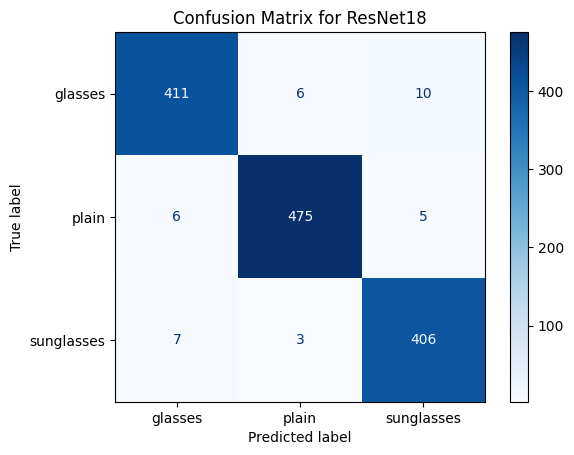

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for ResNet18')
plt.show()

По матрице ошибок видно, что наиболее уверенно классифицируется класс `plain`. Небольшие ошибки наблюдаются между классами `glasses` и `sunglasses`.

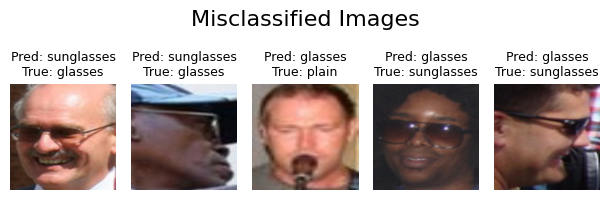

In [ ]:
show_images(
    wrong_images[::9],
    overall_title="Misclassified Images",
    titles=titles[::9]
)

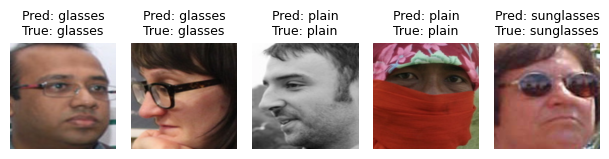

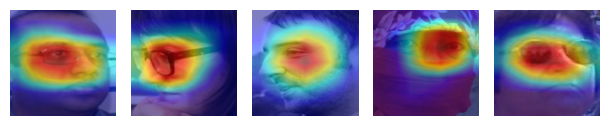

In [ ]:
target_layers = [resnet18.layer4[-1]]
cam = GradCAM(model=resnet18, target_layers=target_layers)

orig_images = []
cam_images = []
titles = []

for i in VAL_SAMPLES:
    img, label = val_dataset[i]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = resnet18(input_tensor)
        pred_class = output.argmax(1).item()

    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    denorm_img = denormalize(img).permute(1, 2, 0).cpu().numpy()
    cam_image = show_cam_on_image(denorm_img, grayscale_cam, use_rgb=True)

    orig_images.append(denorm_img)
    cam_images.append(cam_image)
    titles.append(f"Pred: {CLASS_NAMES[pred_class]}\nTrue: {CLASS_NAMES[label]}")

show_images(orig_images, titles=titles, denorm=False)
show_images(cam_images, denorm=False)


Grad-CAM визуализации показывают, что модель принимает решение, опираясь на области, соответствующие очкам и глазам, что указывает на корректную локализацию признаков.

## 5.2 MobileNet v3 large

In [ ]:
mobilenet = models.mobilenet_v3_large()
mobilenet.classifier[-1] = nn.Linear(mobilenet.classifier[-1].in_features, NUM_CLASSES)

mobilenet.load_state_dict(
    torch.load(os.path.join(MODELS_DIR, 'mobilenet_l_u2_4.pt'), map_location=device))

<All keys matched successfully>

In [ ]:
mobilenet.to(device)
mobilenet.eval()

all_preds = []
all_labels = []

wrong_images = []
titles = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for img, pred, true_label in zip(images, predicted, labels):
            if pred != true_label:
                wrong_images.append(img.cpu())
                titles.append(f"Pred: {CLASS_NAMES[pred]}\nTrue: {CLASS_NAMES[true_label]}")


<Figure size 500x500 with 0 Axes>

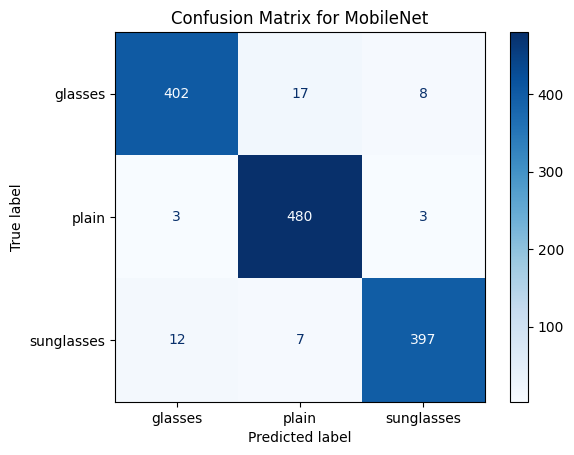

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for MobileNet')
plt.show()

Видно, что по сравнению с предыдущей моделью, наблюдается небольшое снижение точности для классов `glasses` и `sunglasses`: увеличилось число ошибок между ними и с классом `plain`. Класс `plain` по-прежнему классифицируется наиболее уверенно.

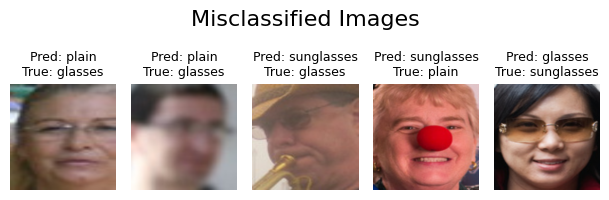

In [ ]:
show_images(
    wrong_images[::10],
    overall_title="Misclassified Images",
    titles=titles[::10]
)

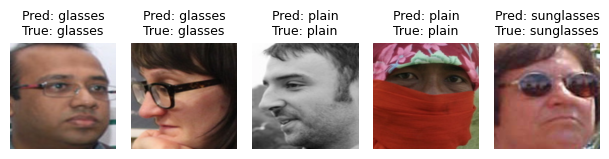

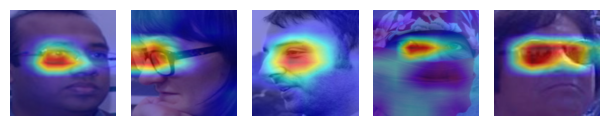

In [ ]:
target_layers = [mobilenet.features[-1]]
cam = GradCAM(model=mobilenet, target_layers=target_layers)

orig_images = []
cam_images = []
titles = []

for i in VAL_SAMPLES:
    img, label = val_dataset[i]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = mobilenet(input_tensor)
        pred_class = output.argmax(1).item()

    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    denorm_img = denormalize(img).permute(1, 2, 0).cpu().numpy()
    cam_image = show_cam_on_image(denorm_img, grayscale_cam, use_rgb=True)

    orig_images.append(denorm_img)
    cam_images.append(cam_image)
    titles.append(f"Pred: {CLASS_NAMES[pred_class]}\nTrue: {CLASS_NAMES[label]}")

show_images(orig_images, titles=titles, denorm=False)
show_images(cam_images, denorm=False)
